<a href="https://colab.research.google.com/github/lkamat/classification/blob/master/HRAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("drive/My Drive/apps/Colab Notebooks")

Use predictive modelling capabilities to predict employee attrition on the IBM dataset.

This notebook is structured as follows:

Exploratory Data Analysis : In this section, we explore the dataset by taking a look at the feature distributions, how correlated one feature is to the other and create some Seaborn and Plotly visualisations
Feature Engineering and Categorical Encoding : Conduct some feature engineering as well as encode all our categorical features into dummy variables
Implementing Machine Learning models : We implement a Random Forest and a Gradient Boosted Model after which we look at feature importances from these respective models

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')


#Load the data
hr_data = pd.read_csv("HR.csv")
hr_data.head(5)




,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [0]:
# Check the number of employees by the education field
hr_data['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

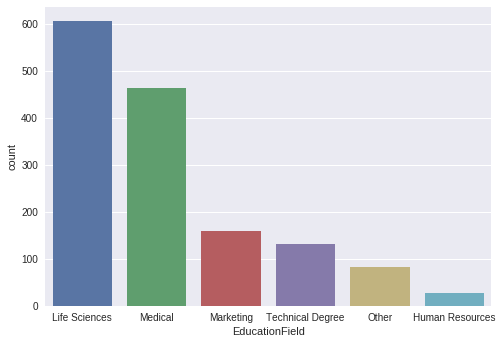

In [0]:
sns.set(style='darkgrid')
sns.countplot(x = 'EducationField',
              data = hr_data,
              order = hr_data['EducationField'].value_counts().index)

In [0]:
# Equivalent way to get average_salary
group = hr_data.groupby('Department')
group

Average daily rate in HR department : 751.54 dollars


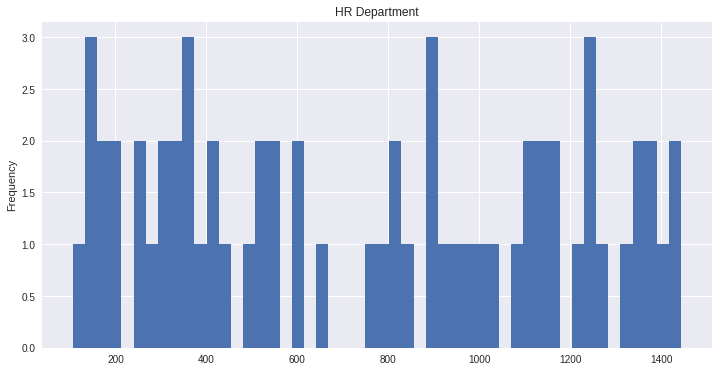

In [0]:
finance_df = group.get_group('Human Resources')
print('Average daily rate in HR department : {:.2f} dollars'.format(
        finance_df['DailyRate'].mean()))

finance_df['DailyRate'].plot(kind='hist', bins=50, figsize=(12, 6), title='HR Department');

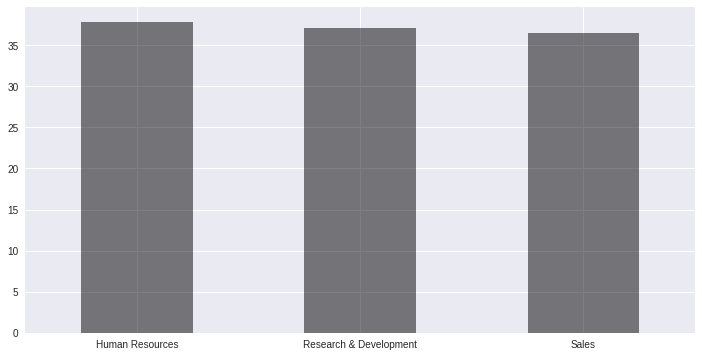

In [0]:
# Equivalent way to get average_salary
group = hr_data['Age'].groupby(hr_data['Department'])
average_salary = group.mean().sort_values(ascending=False)

average_salary.plot(kind='bar', figsize=(12, 6), color='k', alpha=0.5, rot=0);
plt.xlabel("")
plt.show()

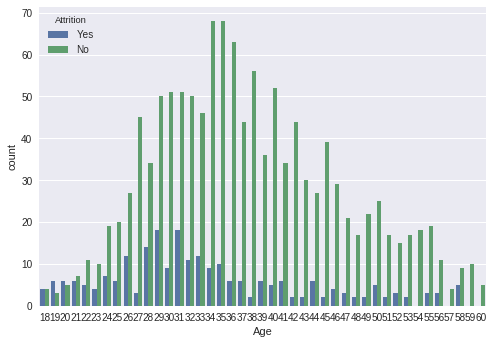

In [0]:
sns.set(style='darkgrid')
sns.countplot(x = 'Age',
              hue= 'Attrition',
              data = hr_data,
              )

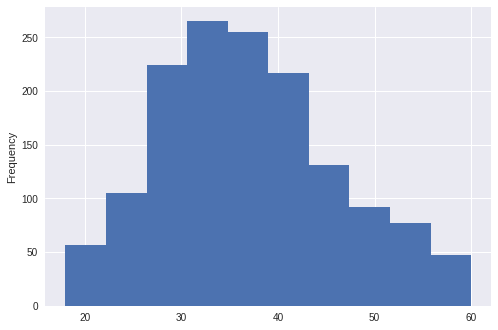

In [0]:
hr_data['Age'].plot.hist()

In [0]:
#Missing values check
hr_data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [0]:
#Check the structure of dataset
hr_data.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [0]:
#Columns of dataset
hr_data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [0]:
#Lets create a dataframe with only numeric variables
hr_data_num = hr_data[['Age','DailyRate','DistanceFromHome', 'Education','EmployeeNumber', 
                       'EnvironmentSatisfaction', 'HourlyRate',                     
                       'JobInvolvement', 'JobLevel','JobSatisfaction','MonthlyIncome', 
                        'MonthlyRate', 'NumCompaniesWorked','PercentSalaryHike', 'PerformanceRating', 
                       'RelationshipSatisfaction', 'StockOptionLevel',
                       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
                       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                       'YearsWithCurrManager']].copy()

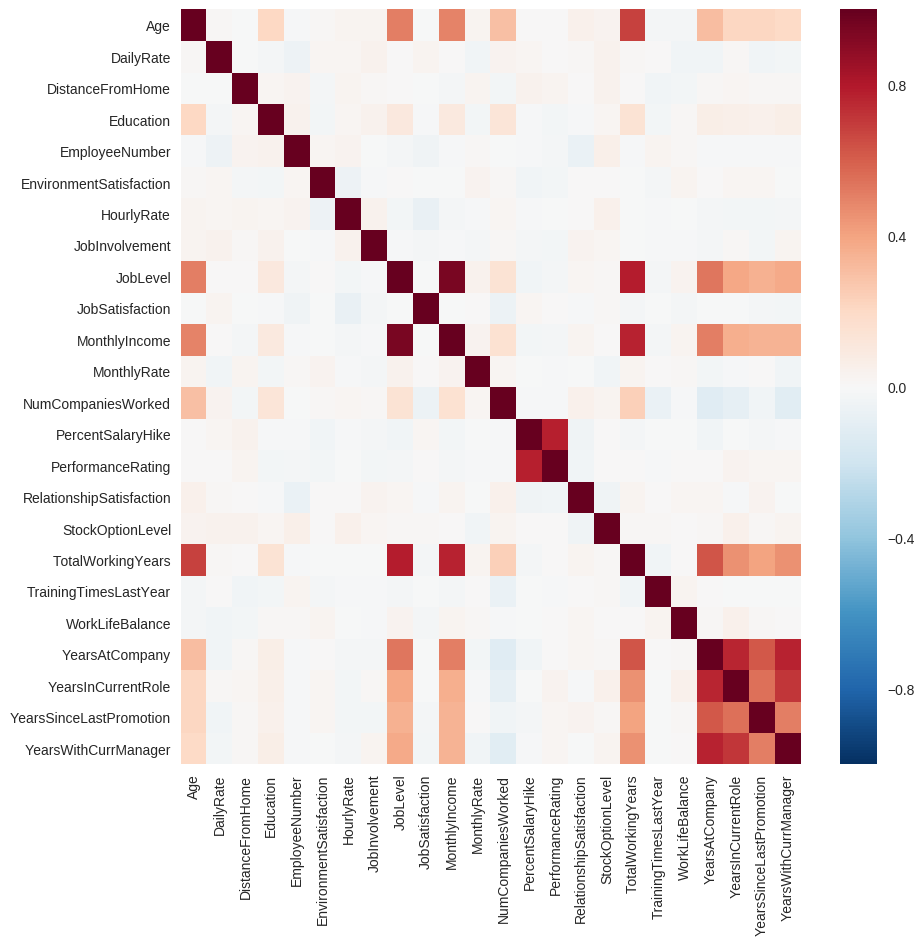

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(hr_data_num.corr())

In [0]:
#Let's remove the strongly correlated variables
hr_data_uc = hr_data_num[['Age','DailyRate','DistanceFromHome', 
                       'EnvironmentSatisfaction', 'HourlyRate',                     
                       'JobInvolvement', 'JobLevel','JobSatisfaction', 
                       'RelationshipSatisfaction', 'StockOptionLevel',
                        'TrainingTimesLastYear']].copy()

hr_data_uc.head()

,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear
0,41,1102,1,2,94,3,2,4,1,0,0
1,49,279,8,3,61,2,2,2,4,1,3
2,37,1373,2,4,92,2,1,3,2,0,3
3,33,1392,3,4,56,3,1,3,3,0,3
4,27,591,2,1,40,3,1,2,4,1,3


In [0]:
#Copy categorical data
hr_data_cat = hr_data[['Attrition', 'BusinessTravel','Department',
                       'EducationField','Gender','JobRole','MaritalStatus',
                       'Over18', 'OverTime']].copy()
hr_data_cat.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


In [0]:
Num_val = {'Yes':1, 'No':0}
hr_data_cat['Attrition'] = hr_data_cat["Attrition"].apply(lambda x: Num_val[x])
hr_data_cat.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,1,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,0,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,1,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,0,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,0,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


In [0]:
hr_data_cat = pd.get_dummies(hr_data_cat)
hr_data_cat.head()

,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,1,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,1,0,1
1,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,1,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
3,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


In [0]:
hr_data_final = pd.concat([hr_data_num, hr_data_cat], axis=1)
hr_data_final.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,1,0,0,0,1,1,0,1
1,49,279,8,1,2,3,61,2,2,2,...,0,1,0,0,0,1,0,1,1,0
2,37,1373,2,2,4,4,92,2,1,3,...,0,0,0,0,0,0,1,1,0,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,1,0,0,0,1,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,0,0,0,0,0,1,0,1,1,0


In [0]:
from sklearn.model_selection import train_test_split

target = hr_data_final['Attrition']
features = hr_data_final.drop('Attrition', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=10)

In [0]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score
test_pred = model.predict(X_test)
accuracy_score(y_test, test_pred)

0.8469387755102041

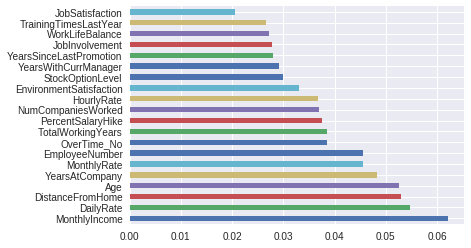

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')

In [0]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(X_train,y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.8350340136054422

In [0]:
seed = 0 
# Gradient Boosting Parameters
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

In [0]:
gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTEd train and target
gb.fit(X_train,y_train)
# Get our predictions
gb_predictions = gb.predict(X_test)
print("Predictions have finished")

Predictions have finished


In [0]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, gb_predictions))

0.8350340136054422
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       483
           1       0.69      0.23      0.34       105

   micro avg       0.84      0.84      0.84       588
   macro avg       0.77      0.60      0.63       588
weighted avg       0.82      0.84      0.81       588



In [0]:
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls



# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = hr_data_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = hr_data_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')
#change to plot to print as an html page

In [0]:
hr_data_final.columns.values

array(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male',
       'JobRole_Healthcare

In [0]:
import plotly
plotly.__version__

'3.6.1'